In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from timeit import default_timer as timer
from numba import njit, jit, vectorize, prange
from matplotlib.animation import FuncAnimation
from IPython import display
import sys
%matplotlib inline

Gradient & loss

In [2]:
@njit
def inrange(idx, shape):
    i, j = idx
    return 0 <= i < shape[0] and 0 <= j < shape[1]

@njit
def color_diff(f1, f0, fore_pix, back_pix):
    if inrange(fore_pix, f1.shape) and inrange(back_pix, f0.shape):
        c1 = f1[fore_pix]
        c2 = f0[back_pix]
        return (abs(c1[0]-c2[0]) + abs(c1[1]-c2[1]) + abs(c1[2]-c2[2]))/3
    else:
        return np.nan

@njit
def pixel_loss(f1, f0, pix0, sc0, sc1, tr):
    tl = (-tr[0] + pix0[0])/sc0, (-tr[1] + pix0[1])/sc1
    br = (-tr[0] + (pix0[0]+1))/sc0, (-tr[1] + (pix0[1]+1))/sc1
    
    tl_i = math.floor(tl[0]), math.floor(tl[1])
    br_i = math.floor(br[0]), math.floor(br[1])
    
    tl_f = min(tl_i[0]+1, br[0])-tl[0], min(tl_i[1]+1, br[1])-tl[1]
    br_f = br[0]-max(br_i[0], tl[0]), br[1]-max(br_i[1], tl[1])

    s = 0.0
    done_corners = set()
    
    # top-left:
    back_pix = (tl_i[0], tl_i[1])
    if back_pix not in done_corners:
        fore_weight = tl_f[0]*tl_f[1]
        incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
        s += incr
        done_corners.add(back_pix)

    # top:
    for j in range(tl_i[1]+1, br_i[1]):
        back_pix = (tl_i[0], j)
        if back_pix not in done_corners:
            fore_weight = tl_f[0]
            incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
            s += incr
            done_corners.add(back_pix)

    # top-right:
    back_pix = (tl_i[0], br_i[1])
    if back_pix not in done_corners:
        fore_weight = tl_f[0]*br_f[1]
        incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
        s += incr
        done_corners.add(back_pix)

    # left:
    for i in range(tl_i[0]+1, br_i[0]):
        back_pix = (i, tl_i[1])
        if back_pix not in done_corners:
            fore_weight = tl_f[1]
            incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
            s += incr
            done_corners.add(back_pix)

    # center:
    for i in range(tl_i[0]+1, br_i[0]):
        for j in range(tl_i[1]+1, br_i[1]):
            back_pix = i, j
            s += color_diff(f1, f0, back_pix, pix0)


    # right:
    for i in range(tl_i[0]+1, br_i[0]):
        back_pix = (i, br_i[1])
        if back_pix not in done_corners:
            fore_weight = (br_f[1])
            incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
            s += incr
            done_corners.add(back_pix)

    # bottom-left:
    back_pix = (br_i[0], tl_i[1])
    if back_pix not in done_corners:
        fore_weight = br_f[0]*tl_f[1]
        incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
        s += incr
        done_corners.add(back_pix)

    #bottom:
    for j in range(tl_i[1]+1, br_i[1]):
        back_pix = (br_i[0], j)
        if back_pix not in done_corners:
            fore_weight = (br_f[0])
            incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
            s += incr
            done_corners.add(back_pix)

    # bottom-right:
    back_pix = (br_i[0], br_i[1])
    if back_pix not in done_corners:
        fore_weight = br_f[0]*br_f[1]
        incr = fore_weight * color_diff(f1, f0, back_pix, pix0)
        s += incr
        done_corners.add(back_pix)
    
    s = s * sc0*sc1 * (sc0/sc1 if sc0/sc1 > 1. else sc1/sc0)
    # assert s <= 1.
    return s

@njit
def losses(f1, x, f0=None, inds=None):
    sc0 = (x[2] - x[0] + f1.shape[0])/f1.shape[0]
    sc1 = (x[3] - x[1] + f1.shape[1])/f1.shape[1]
    tr = x[0], x[1]
    
    if f0 is None:
        f0 = np.zeros_like(f1)
        
    if inds is None:
        inds = np.zeros((f0.shape[0]*f0.shape[1], 2), dtype=np.int64)
        for i in range(len(inds)):
            inds[i] = i//f0.shape[1], i%f0.shape[1]

    return np.array([pixel_loss(f1, f0, (i, j), sc0, sc1, tr) for i, j in inds])

@njit
def gradient(f1, x, f0, dx = 1e-4, nbatches=6, do_filter=True): #1e-4
    inds = np.zeros((f1.shape[0]*f1.shape[1], 2), dtype=np.int64)
    for i in range(len(inds)):
        inds[i] = i//f1.shape[1], i%f1.shape[1]
    
    if do_filter:
        inds = inds[np.random.choice(np.arange(len(inds)), size=len(inds)//nbatches, replace=False)]

    y0 = losses(f1, x, f0, inds)
    
    nfeats = len(x)
    mat = x.repeat(nfeats).reshape((-1, nfeats)).T + np.identity(nfeats)*dx
    
    dy = np.zeros(len(x))
    for i in range(len(mat)):
        dy[i] = np.nanmean((losses(f1, mat[i], f0, inds) - y0)/dx)

    return dy, np.nanmean(y0)

Fast transform for visualization (not used for gradient)

In [3]:
def transform(img, x, bv=1.):
    sc0 = (x[2] - x[0] + img.shape[0])/img.shape[0]
    sc1 = (x[3] - x[1] + img.shape[1])/img.shape[1]
    
    rows, cols = img.shape[0], img.shape[1]
    map_x = np.array([
        [i for i in np.linspace(-x[1]/sc1, -x[1]/sc1 + (cols-1)/sc1, cols)]
        ], dtype=np.float32).repeat(img.shape[0], axis=0)
    map_y = np.array([
        [i for i in np.linspace(-x[0]/sc0, -x[0]/sc0 + (rows-1)/sc0, rows)]
        ], dtype=np.float32).repeat(img.shape[1], axis=0).T
        
    return cv.remap(img, map_x, map_y, interpolation=cv.INTER_AREA, borderValue=(bv, bv, bv))

Function to match `f1` onto `f0`:

In [4]:
def fit(f1, f0, lr0=8e-5 * 915840, nbatches=40, m=0.97): #5e-6, 0.975
    dy = f0.shape[0]-f1.shape[0]
    dx = f0.shape[1]-f1.shape[1]
    f1_padded = np.pad(f1, pad_width=[(0, dy), (0, dx), (0, 0)], constant_values=0.)

    x = np.array([0., 0., 0.01, 0.01])
    # x = np.array([39.6, 97.6, -124.1, -146.3])
    𝛅x = 0.1*np.array([-1., -1., 1., 1.])
    loss = 1.
    hist = np.zeros((30, len(x)))
    hist_idx = 0
    
    for i in range(10_000):
        # lr = lr0/(1+i/1500)
        lr = lr0
        
        hist[hist_idx] = x.dot(x)**.5
        hist_idx = (hist_idx+1)%len(hist)
        ptp = np.ptp(hist)

        is_done = i > len(hist) and ptp < 1. and loss < 0.06

        if i%5 == 0 or is_done:
            yield f"iter. {i}: x=({', '.join(f'{xi:.1f}' for xi in x)}), {loss=:.4f}, {ptp=:.1f}", np.sqrt(transform(f1_padded, x) *  f0)
            
        if is_done:
            break
            
        grad, loss = gradient(f1, x, f0, nbatches=nbatches)

        𝛅x = lr * grad + m * 𝛅x
        x -= 𝛅x

    return x, loss

Load images:

In [5]:
fl0, fl1 = cv.imread('00.png')[:,:,::-1]/255, cv.imread('01.png')[:,:,::-1]/255

Match with visualization:

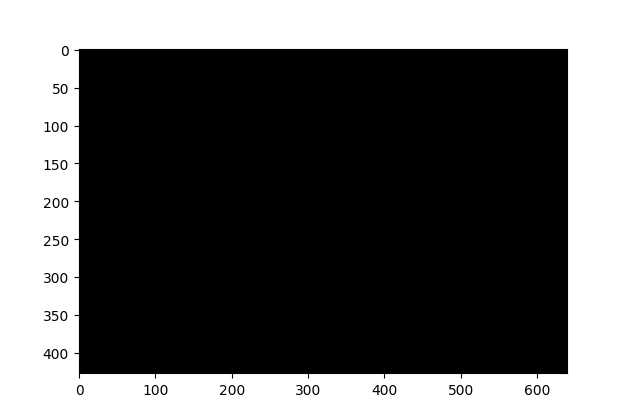

In [9]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(4.5*1.4, 3.0*1.4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

img = ax.imshow(np.zeros(fl0.shape[:3]), aspect='auto', cmap='gray', vmin=0., vmax=1.)

def animate(data):
    msg, frame = data
    ax.set_title(msg)
    img.set_data(frame)
    return img

def on_click(event):
    global is_running
    if is_running:
        anim.event_source.stop()
    else:
        anim.event_source.start()
        
    is_running = not is_running

anim = FuncAnimation(fig, animate, frames=lambda: (yield from fit((fl1), (fl0))), interval=200, repeat=False, cache_frame_data=False,  save_count=sys.maxsize)
is_running=True
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()

Save visualization:

In [8]:
# anim.save('out.mp4', fps=20, bitrate=700)